## ATMS 523 (Weather and Climate Data Analytics) — Module 6 Project: Feature Engineering and XAI  
**By: Nathan Makowski**  
**Date: 11/19/2025**

This notebook completes the ATMS 523 Module 6 Project, submitted via GitHub Classroom. I use the SPC tornado dataset (1950–2021) and the ENSO, PDO, NAO, and AO indices created in Module 4.

### **Objective**
Create a monthly tornado count for IL, IN, WI, MI, MO, IA, and MN, merge it with the four climate indices, and build Random Forest models to understand and predict monthly tornado activity.

### **Tasks**
- Aggregate tornado reports into monthly counts for the seven states.  
- Merge with ENSO, PDO, NAO, and AO monthly indices.  
- Train a baseline RF model (indices only); report RMSE, correlation, and predicted vs. observed scatter.  
- Add one-hot month variables and repeat the analysis.  
- Compute feature importance and multipass permutation importance.  
- Produce SHAP summary plot and ENSO dependence plot.  
- Summarize key findings on feature relevance and model behavior.

## 1. Setup and imports

This section loads all required Python libraries for data manipulation, visualization, and machine learning.  
I will use:

- **pandas**, **numpy** for data handling  
- **matplotlib**, **seaborn** for plotting  
- **scikit-learn** for Random Forests, scaling, metrics, and permutation importance  
- **joblib** for saving models  
- **shap** for model explainability  

In [1]:
# Code cell: imports and settings
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import shap
import joblib
from scipy.stats import pearsonr

# For reproducibility
RND = 42
np.random.seed(RND)

# plotting defaults
plt.rcParams.update({'figure.figsize': (8,5), 'font.size': 12})

## 2. Load tornado dataset (SPC) and preprocess

**Goal:** Load the SPC tornado dataset (1950–2021) and aggregate tornado counts into **monthly totals** for the following states:

- Illinois (IL)  
- Indiana (IN)  
- Wisconsin (WI)  
- Michigan (MI)  
- Missouri (MO)  
- Iowa (IA)  
- Minnesota (MN)

Steps:

1. Read the SPC CSV file containing all U.S. tornado reports.  
2. Filter rows for the seven states of interest.  
3. Convert the tornado dates to a proper datetime index.  
4. Create a monthly count time series (number of tornadoes per month across all selected states).  
5. Prepare this monthly series for merging with climate indices.

In [2]:
# Code cell: load SPC tornado CSV
spc_url = "https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv"
torn = pd.read_csv(spc_url, low_memory=False)

# quick look
print(torn.columns)
torn.head()

Index(['om', 'yr', 'mo', 'dy', 'date', 'time', 'tz', 'st', 'stf', 'stn', 'mag',
       'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len',
       'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4', 'fc'],
      dtype='object')


,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,15.8,10,1,1,1,25,0,0,0,0
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,2.0,880,1,1,1,47,0,0,0,0
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,0.1,10,1,1,1,177,0,0,0,0
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,0.1,10,1,1,1,209,0,0,0,0
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,2.0,37,1,1,1,101,0,0,0,0


In [3]:
# Inspect likely columns and normalize names (robust to slight differences)
torn_cols = [c.lower() for c in torn.columns]
# attempt to find year/month/state fields
print("Columns lowercased:", torn_cols)

Columns lowercased: ['om', 'yr', 'mo', 'dy', 'date', 'time', 'tz', 'st', 'stf', 'stn', 'mag', 'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len', 'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4', 'fc']


In [ ]:
# Try common names
# I'll try a few alternatives for Year, Month, State
year_col = None
month_col = None
state_col = None
for c in torn.columns:
    cl = c.lower()
    if cl in ['yr', 'year', 'yr.']:
        year_col = c
    if cl in ['mo', 'month', 'mo.']:
        month_col = c
    if cl in ['st', 'state', 'state_abbrev', 'state.']:
        state_col = c

# Fallback: try to detect heuristically
if year_col is None:
    for c in torn.columns:
        if 'year' in c.lower() or c.lower().startswith('yr'):
            year_col = c
            break
if month_col is None:
    for c in torn.columns:
        if 'month' in c.lower() or c.lower().startswith('mo'):
            month_col = c
            break
if state_col is None:
    for c in torn.columns:
        if 'state' in c.lower() or c.lower() == 'st':
            state_col = c
            break

print("Detected columns - year:", year_col, "month:", month_col, "state:", state_col)

Detected columns - year: yr month: mo state: st


In [23]:
# Filter to the states of interest (two-letter abbreviations)
states_of_interest = ["IL","IN","WI","MI","MO","IA","MN"]

# Ensure state column uppercased and strip whitespace
torn[state_col] = torn[state_col].astype(str).str.strip().str.upper()

# Keep only those states
torn_sel = torn[torn[state_col].isin(states_of_interest)].copy()

# Create a datetime index and monthly period
torn_sel['year'] = torn[year_col].astype(int)
torn_sel['month'] = torn[month_col].astype(int)
torn_sel['day'] = 1  # we only care about month
torn_sel['Date'] = pd.to_datetime(dict(year=torn_sel['year'], month=torn_sel['month'], day=1))

# Aggregate monthly counts across the selected states
monthly_counts = torn_sel.groupby('Date').size().rename('tornado_count').to_frame()

# To ensure continuous monthly index from the earliest to the latest date in the climate indices,
# I'll reindex later to match the climate index date range.
monthly_counts = monthly_counts.sort_index()
monthly_counts.head()

,tornado_count
Date,
1950-01-01,4
1950-03-01,1
1950-05-01,2
1950-06-01,10
1950-07-01,6


## 3. Reconstruct ENSO/PDO/NAO/AO monthly DataFrame

Using methods adapted from Module 4 Notebook 1, I rebuild monthly climate indices:

- **ENSO** (El Nino Southern Oscillation or Oceanic Niño Index or similar standardized ENSO metric)  
- **PDO**  (Pacific Decadal Oscillation)
- **NAO**  (North Atlantic Oscillation)
- **AO**   (Arctic Oscillation)

These are combined into a single DataFrame (`newdf_all`) with:

- A **Date** index at monthly frequency (YYYY-MM-01)
- Four columns: ENSO, PDO, NAO, AO

This ensures consistent alignment with the tornado monthly series.

In [6]:
# Code cell: load indices (exactly like Module 4 snippet)
enso = pd.read_csv('https://www.atmos.illinois.edu/~snesbitt/soi.dat',sep=r'\s+',header=None,skiprows=4, engine='python')
pdo = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat',sep=r'\s+',header=None,skiprows=2, engine='python')
nao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')
ao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')

In [7]:
# Build long-form timeseries for each index
def matrix_to_monthly_df(mat, value_name):
    # mat: DataFrame where col 0 is year, col 1-12 are months
    years = mat.iloc[:,0].astype(int).values
    months = mat.iloc[:,1:].values  # shape (n_years,12)
    # create date_index spanning from first year Jan to last year Dec
    start = datetime.datetime(years[0],1,1)
    end = datetime.datetime(years[-1],12,1)
    dates = pd.date_range(start=start, end=end, freq='MS')
    # flatten months row-wise
    vals = months.flatten()
    df = pd.DataFrame({ 'Date': dates, value_name: vals })
    df = df.set_index('Date')
    return df

enso_new = matrix_to_monthly_df(enso, 'ENSO')
pdo_new = matrix_to_monthly_df(pdo, 'PDO')
nao_new = matrix_to_monthly_df(nao, 'NAO')
ao_new  = matrix_to_monthly_df(ao, 'AO')

# Combine into a single DataFrame
newdf_all = enso_new.join([pdo_new, nao_new, ao_new], how='outer')
# Convert sentinel missing values to NaN if present (like -99.9 or 99.99)
newdf_all.replace([-99.9, 99.99, 99.9, -999., 999.], np.nan, inplace=True)

newdf_all = newdf_all.sort_index()
print(newdf_all.head())
print(newdf_all.tail())

            ENSO   PDO  NAO  AO
Date                           
1854-01-01   NaN  0.11  NaN NaN
1854-02-01   NaN -0.24  NaN NaN
1854-03-01   NaN -0.40  NaN NaN
1854-04-01   NaN -0.44  NaN NaN
1854-05-01   NaN -0.54  NaN NaN
            ENSO   PDO   NAO     AO
Date                               
2025-08-01   0.4 -3.20  0.26  0.036
2025-09-01   0.0 -2.33 -0.80  0.048
2025-10-01   NaN -2.40 -0.96  0.064
2025-11-01   NaN   NaN   NaN    NaN
2025-12-01   NaN   NaN   NaN    NaN


## 4. Merge tornado monthly counts with the climate indices

I merge the tornado monthly counts with the ENSO/PDO/NAO/AO dataset:

- Align datasets by monthly Date index  
- Use an outer join to keep the full timeline used in climate indices  
- Months with zero tornadoes (very common in fall/winter) are explicitly filled with **0**  
- This step ensures the regression models have a complete continuous monthly time series

The merged dataset will serve as the input for modeling.

In [8]:
# Code cell: create full monthly index covering climate data range
start = newdf_all.index.min()
end = newdf_all.index.max()
full_index = pd.date_range(start=start, end=end, freq='MS')

# Reindex monthly_counts to the full range; fill missing months with 0 (no tornadoes)
monthly_counts_all = monthly_counts.reindex(full_index).fillna(0)
monthly_counts_all.index.name = 'Date'

# Combine with climate indices
df = monthly_counts_all.join(newdf_all, how='left')

# Drop months with NaN in all indices (or choose to forward/backfill if appropriate).
# For modeling, we prefer to drop months where the climate indices are NaN.
df = df.dropna(subset=['ENSO','PDO','NAO','AO'], how='any')

# Inspect
print("Data range after merge:", df.index.min(), df.index.max())
print(df.head())
print(df.tail())

Data range after merge: 1951-01-01 00:00:00 2025-09-01 00:00:00
            tornado_count  ENSO   PDO   NAO     AO
Date                                              
1951-01-01            0.0   1.5 -1.19  0.08 -0.085
1951-02-01            0.0   0.9 -1.52  0.70 -0.400
1951-03-01            1.0  -0.1 -1.72 -1.02 -1.934
1951-04-01            0.0  -0.3 -1.35 -0.22 -0.776
1951-05-01            2.0  -0.7 -1.29 -0.59 -0.863
            tornado_count  ENSO   PDO   NAO     AO
Date                                              
2025-05-01            0.0   0.4 -1.66  0.49  0.904
2025-06-01            0.0   0.3 -2.62  0.70  1.134
2025-07-01            0.0   0.6 -4.16  0.48  0.500
2025-08-01            0.0   0.4 -3.20  0.26  0.036
2025-09-01            0.0   0.0 -2.33 -0.80  0.048


## 5. Baseline Random Forest model (ENSO, PDO, NAO, AO only)

**Objective:** Establish a baseline model to predict monthly tornado counts from the four climate indices.

Method:

- Use a **time-based split**:  
  - Training: up to 2010-12-31  
  - Testing: 2011-01-01 onward  
- Fit a `RandomForestRegressor` on the four climate predictors  
- Evaluate performance using:  
  - **RMSE** (root mean squared error)  
  - **Pearson correlation coefficient** between predicted and observed counts  
- Create a **scatter plot** of observed vs. predicted values to visualize general model skill

This baseline helps quantify how much predictive power the climate indices alone provide.

In [9]:
# Code cell: prepare features and target
features_basic = ['ENSO','PDO','NAO','AO']
target = 'tornado_count'

df_model = df.copy()

# Time-based split
split_date = '2010-12-31'   # adjust as desired
train = df_model.loc[df_model.index <= split_date].copy()
test  = df_model.loc[df_model.index > split_date].copy()

X_train = train[features_basic].values
y_train = train[target].values
X_test  = test[features_basic].values
y_test  = test[target].values

# Optionally scale features (not strictly necessary for RF, but helps for e.g. permutation importance comparability)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Fit random forest
rf_basic = RandomForestRegressor(n_estimators=500, random_state=RND, n_jobs=-1)
rf_basic.fit(X_train_s, y_train)

# Predict
y_pred_test = rf_basic.predict(X_test_s)

# Metrics
rmse_basic = np.sqrt(mean_squared_error(y_test, y_pred_test))
corr_basic, pval_basic = pearsonr(y_test, y_pred_test)

print(f"Baseline RF (ENSO,PDO,NAO,AO) -- Test RMSE: {rmse_basic:.3f}, Pearson r: {corr_basic:.3f} (p={pval_basic:.3e})")


Baseline RF (ENSO,PDO,NAO,AO) -- Test RMSE: 25.462, Pearson r: 0.089 (p=2.405e-01)


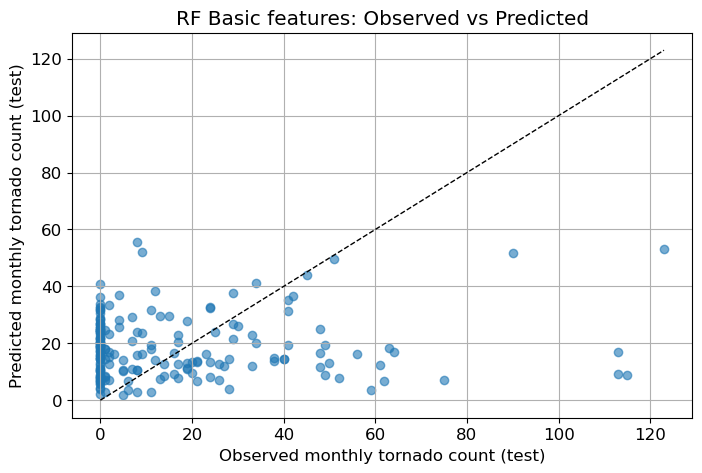

In [10]:
# Scatter plot observed vs predicted
plt.figure()
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel('Observed monthly tornado count (test)')
plt.ylabel('Predicted monthly tornado count (test)')
plt.title('RF Basic features: Observed vs Predicted')
plt.grid(True)
plt.show()

#The model incidcates a more cautious behavior when predicting monthly tornado counts. 

## 6. Add month one-hot encoding and repeat the Random Forest model

To capture the strong seasonality of tornado frequency, I:

1. Add **12 one-hot encoded month features**, `month_1` through `month_12`.  
2. Refit the Random Forest with both:  
   - ENSO, PDO, NAO, AO  
   - Month one-hot variables  
3. Recompute RMSE and Pearson correlation on the test set  
4. Plot observed vs. predicted values again

Comparing metrics with the baseline reveals how much predictive skill is gained from **including** explicit seasonal information.

In [11]:
# Code cell: one-hot encode month
df_onehot = df_model.copy()
df_onehot['month'] = df_onehot.index.month
month_dummies = pd.get_dummies(df_onehot['month'], prefix='M', drop_first=False)  # keep all 12
df_onehot = pd.concat([df_onehot, month_dummies], axis=1)

# features = indices + all month dummies
month_cols = [c for c in df_onehot.columns if c.startswith('M_') or c.startswith('M')]
# detect names robustly
month_cols = [c for c in df_onehot.columns if c.startswith('M_') or c.startswith('M')]
# You may have 'M_1' or 'M_01' naming depending on get_dummies; let's list:
month_cols = [c for c in df_onehot.columns if c.startswith('M')]
features_with_month = features_basic + month_cols

# Split same way
train_oh = df_onehot.loc[df_onehot.index <= split_date].copy()
test_oh  = df_onehot.loc[df_onehot.index > split_date].copy()

X_train_oh = train_oh[features_with_month].values
X_test_oh  = test_oh[features_with_month].values
y_train_oh = train_oh[target].values
y_test_oh  = test_oh[target].values

scaler_oh = StandardScaler()
X_train_oh_s = scaler_oh.fit_transform(X_train_oh)
X_test_oh_s  = scaler_oh.transform(X_test_oh)

rf_oh = RandomForestRegressor(n_estimators=500, random_state=RND, n_jobs=-1)
rf_oh.fit(X_train_oh_s, y_train_oh)
y_pred_oh = rf_oh.predict(X_test_oh_s)

rmse_oh = np.sqrt(mean_squared_error(y_test_oh, y_pred_oh))
corr_oh, pval_oh = pearsonr(y_test_oh, y_pred_oh)

print(f"RF with months one-hot -- Test RMSE: {rmse_oh:.3f}, Pearson r: {corr_oh:.3f} (p={pval_oh:.3e})")


RF with months one-hot -- Test RMSE: 23.315, Pearson r: 0.382 (p=1.589e-07)


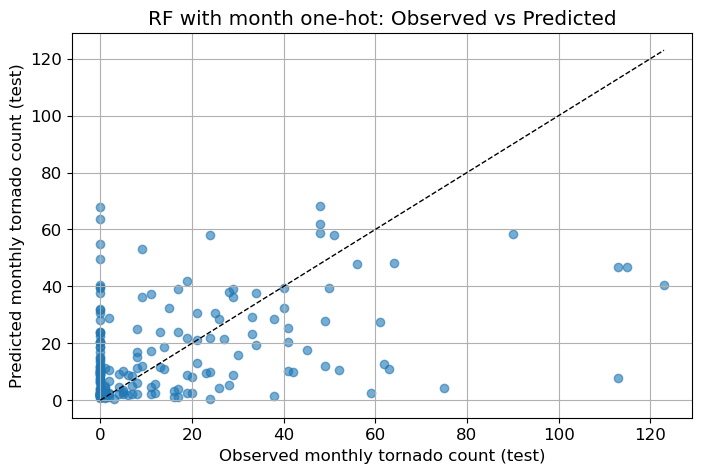

In [12]:
# Scatter
plt.figure()
plt.scatter(y_test_oh, y_pred_oh, alpha=0.6)
plt.plot([y_test_oh.min(), y_test_oh.max()], [y_test_oh.min(), y_test_oh.max()], 'k--', lw=1)
plt.xlabel('Observed monthly tornado count (test)')
plt.ylabel('Predicted monthly tornado count (test)')
plt.title('RF with month one-hot: Observed vs Predicted')
plt.grid(True)
plt.show()

#Still the model is cautious when predicting monthly tornado counts, doesn't seem to capture the monthly extremes quite as good.  

## 7. Feature importance and repeated permutation analysis

I assess model interpretability using two complementary approaches:

### Gini importance
Directly from the Random Forest (`feature_importances_`), showing which predictors the model relied on most.

### Permutation importance (multiple passes)
Using `sklearn.inspection.permutation_importance`:

- Repeated many times (e.g., 30 repeats) for stability  
- Produces mean importance and standard deviation  
- Helps distinguish genuinely useful features from noisy ones

This analysis highlights which months and which climate indices most strongly influence tornado count predictions.

In [13]:
# Code cell: feature importances from RF (Gini)
feat_names_basic = features_basic
fi_basic = pd.Series(rf_basic.feature_importances_, index=feat_names_basic).sort_values(ascending=False)
print("Gini feature importances (basic):")
print(fi_basic)

#A higher Gini importance score indicates that a feature is more influential in making predictions. 

Gini feature importances (basic):
AO      0.307170
NAO     0.272114
PDO     0.258356
ENSO    0.162360
dtype: float64


In [14]:
# For the model with months:
feat_names_oh = features_with_month  # ensure ordering matches X_train_oh_s
fi_oh = pd.Series(rf_oh.feature_importances_, index=feat_names_oh).sort_values(ascending=False)
print("\nTop 10 Gini feature importances (with months):")
print(fi_oh.head(10))


Top 10 Gini feature importances (with months):
M_6     0.175818
NAO     0.151858
PDO     0.151184
AO      0.143409
ENSO    0.133501
M_5     0.111137
M_4     0.052018
M_7     0.049339
M_8     0.016158
M_3     0.006472
dtype: float64


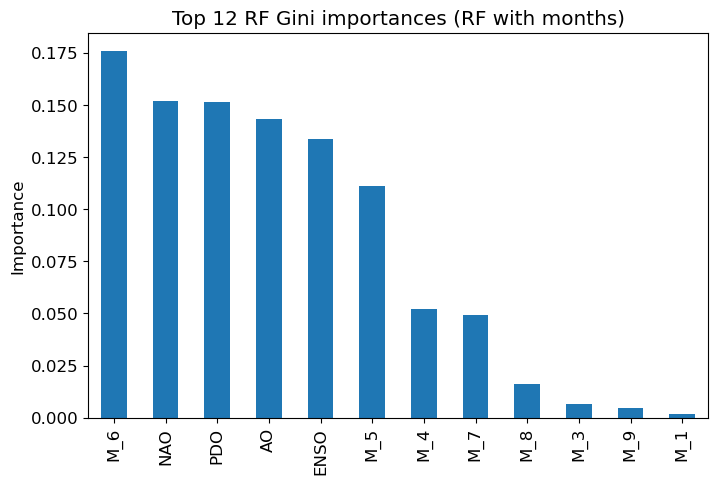

In [15]:
# Plot top 12
plt.figure()
fi_oh.head(12).plot(kind='bar')
plt.title('Top 12 RF Gini importances (RF with months)')
plt.ylabel('Importance')
plt.show()

In [16]:
# Code cell: multipass permutation importance (averaged)
from tqdm.auto import tqdm

def repeated_permutation_importance(model, X, y, feature_names, n_repeats=30, random_seed=RND):
    results = []
    for i in tqdm(range(n_repeats), desc="Permutation repeats"):
        ri = permutation_importance(model, X, y, n_repeats=1, random_state=random_seed + i, n_jobs=-1, scoring='neg_root_mean_squared_error')
        # permutation_importance returns importances as decrease in score; convert to positive importance metric
        # sklearn returns importances_ array where larger is more important.
        imp = ri.importances_mean  # mean over the n_repeats inner repeats
        results.append(imp)
    arr = np.vstack(results)  # shape (n_repeats, n_features)
    mean_imp = arr.mean(axis=0)
    std_imp = arr.std(axis=0)
    df_imp = pd.DataFrame({'feature': feature_names, 'perm_mean': mean_imp, 'perm_std': std_imp})
    df_imp = df_imp.sort_values('perm_mean', ascending=False).reset_index(drop=True)
    return df_imp

# apply to the model with months on the test set
X_test_for_perm = X_test_oh_s
df_perm = repeated_permutation_importance(rf_oh, X_test_for_perm, y_test_oh, feat_names_oh, n_repeats=30)
df_perm.head(20)

Permutation repeats:   0%|          | 0/30 [00:00<?, ?it/s]

,feature,perm_mean,perm_std
0,M_6,2.813717,0.771993
1,M_5,2.791131,0.623743
2,M_7,1.189625,0.292625
3,M_4,1.129242,0.434731
4,M_8,0.534495,0.145525
5,NAO,0.483563,0.512631
6,ENSO,0.369447,0.542817
7,PDO,0.223566,0.318654
8,AO,0.193583,0.508043
9,M_9,0.171627,0.074796


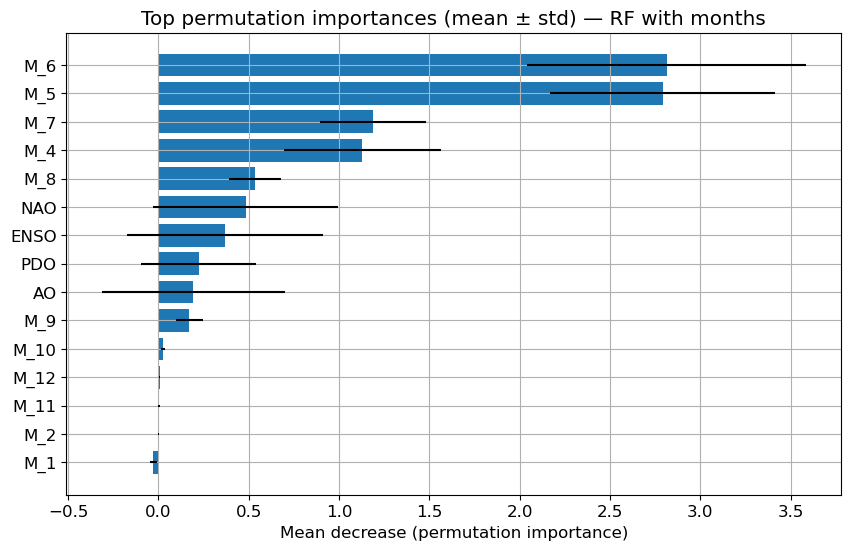

In [17]:
# Code cell: plot top 15 perm importances
plt.figure(figsize=(10,6))
topn = 15
plt.barh(df_perm['feature'].iloc[:topn][::-1], df_perm['perm_mean'].iloc[:topn][::-1], xerr=df_perm['perm_std'].iloc[:topn][::-1])
plt.xlabel('Mean decrease (permutation importance)')
plt.title('Top permutation importances (mean ± std) — RF with months')
plt.grid(True)
plt.show()

## 8. SHAP analysis — summary plot and ENSO dependence

I use **SHAP (SHapley Additive exPlanations)** to interpret the Random Forest model with month one-hot encoding.

Notes:

- I used `shap.TreeExplainer` with `"interventional"` perturbation.
- For scikit-learn `RandomForestRegressor`, SHAP commonly triggers an additivity warning; the recommended and safe fix is:
  - `check_additivity=False` in `.shap_values()`
- SHAP values help us understand:
  - Global feature impact (summary plot)
  - How ENSO influences tornado predictions (ENSO dependence plot)
  - Interactions between ENSO and seasonal months if present

SHAP provides a more nuanced explanation of nonlinear contributions compared to Gini or permutation importance.

 95%|=================== | 168/177 [00:16<00:00]       /tmp/ipykernel_3204/2372860764.py:25: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, feature_names=feat_names_oh, show=True)


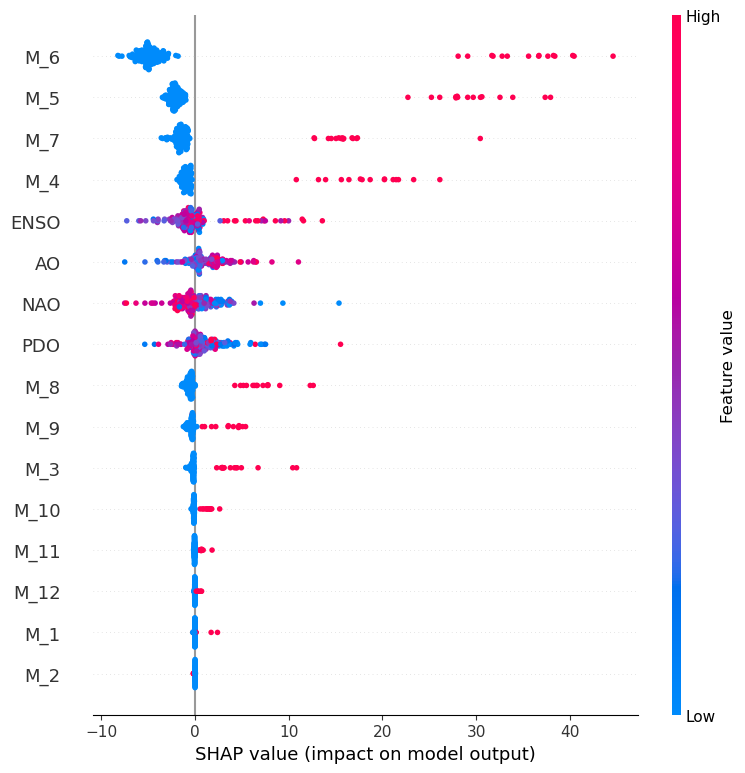

In [ ]:
# Code cell: SHAP explainer and summary plot
# Use a small background sample (recommended by SHAP)
# I'll adjust n_background upward if I want more accuracy.
n_background = 300
background_idx = np.random.choice(X_train_oh_s.shape[0], 
                                  size=min(n_background, X_train_oh_s.shape[0]),
                                  replace=False)
background = X_train_oh_s[background_idx]

# Create TreeExplainer using "interventional" mode
explainer = shap.TreeExplainer(
    rf_oh,
    data=background,
    feature_perturbation="interventional"
)

# Compute SHAP values for the test set (or subset for speed)
X_shap = X_test_oh_s  # could also do X_test_oh_s[:1000]
shap_values = explainer.shap_values(X_shap, check_additivity=False)

# Convert to DataFrame for convenience
shap_df = pd.DataFrame(shap_values, columns=feat_names_oh)

# Plot summary
shap.summary_plot(shap_values, X_shap, feature_names=feat_names_oh, show=True)

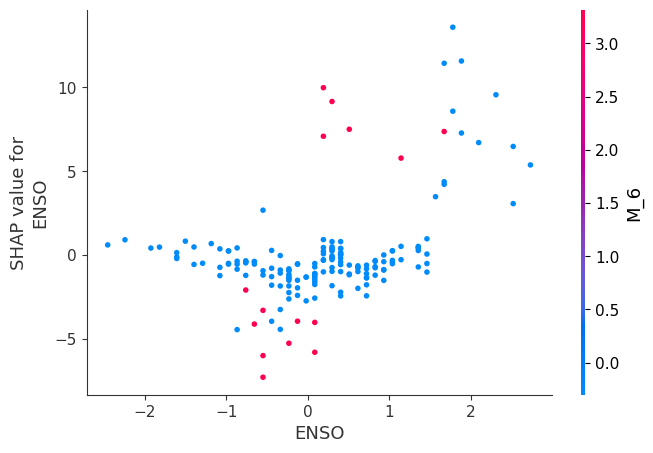

In [19]:
# Code cell: SHAP dependence plot for ENSO
# find the ENSO column index
if 'ENSO' in feat_names_oh:
    shap.dependence_plot('ENSO', shap_values, X_shap, feature_names=feat_names_oh, show=True)
else:
    print("ENSO not found in features (unexpected).")

## 9. Observations & Summarized Findings

### Key numeric results
- Dataset: **897 months** (1951–2025), **13,959 total tornadoes**, **~28%** of months have zero tornadoes.  
- **Baseline RF (ENSO, PDO, NAO, AO):** Test RMSE = **25.46**, Pearson r = **0.089** (p ≈ 0.24) — very weak linear correlation; indices alone explain little variance.  
- **RF + month one-hot:** Test RMSE = **23.32**, Pearson r = **0.382** (p ≈ 1.6e-07) — clear improvement: seasonality adds meaningful predictive power.

### Interpretation — seasonality vs climate indices
- Adding month dummies substantially improves correlation and modestly reduces RMSE, indicating **seasonal cycle** is the dominant predictable component of monthly tornado counts (expected: spring/summer peak).
- Climate indices (ENSO/PDO/NAO/AO) alone have limited skill at monthly-count prediction over this region and time horizon.

### Feature importance (summary of results)
- **Gini importances (RF):** Month features (especially **M_6**, **M_5**) dominate; NAO/PDO/AO/ENSO follow behind.  
- **Permutation importance (multi-pass):** Confirms months (M_6, M_5, M_7, M_4) are most influential; among indices, **NAO** and **ENSO** show modest importance (mean decrease > 0), PDO and AO smaller. Permutation std devs indicate some uncertainty for index importances — effects are weaker and less stable than seasonal signals.

### SHAP insights
- **SHAP summary plot:** Month features have the largest |SHAP| values (largest global impact). ENSO and NAO appear as secondary contributors.  
- **ENSO dependence plot:** ENSO shows **nonlinear behavior** — generally weak effect overall, but **positive ENSO values can be associated with increased SHAP contributions in peak-months** (M_6 coloring on the dependence plot). In other words, ENSO’s influence is small on average but can amplify predicted counts during seasonal windows (interaction with month).

### Data characteristics & caveats
- The tornado-count distribution is **highly skewed** (median = 6, max = 192). This leads to large RMSE sensitivity to extreme months.  
- Nearly 28% zero-months and many small counts suggest count-specific models (Poisson/negative-binomial, zero-inflated, or log/sqrt transforms) could be more appropriate than raw regression.  
- Missing or sentinel values in index series (e.g., -99.9, NaNs at dataset ends) must be handled carefully — we dropped months with NaNs in indices, which shortens the sample at the tail.

### Practical recommendations / next steps
1. **Modeling changes**
   - Try **count models** (Poisson, negative binomial, zero-inflated) or transform target (sqrt or log(1+count)).  
   - Explore **lagged indices** (ENSO/PDO/NAO/AO at 1–3 month lags) — physical teleconnections often have lagged impacts.  
2. **Predictor expansion**
   - Add physically relevant predictors (monthly CAPE, 0–6 km shear, MJO indices, large-scale moisture/temperature anomalies).  
   - Consider regional synoptic predictors (e.g., frequency of favorable shear/CAPE days).  
3. **Validation**
   - Use **rolling-origin (time-series) cross-validation** to robustly estimate predictive skill and avoid leakage.  
4. **XAI and stability**
   - Combine SHAP, permutation importance, and bootstrapped feature importances for robust inference.  
   - Report both global importance (mean |SHAP|) and conditional interactions (SHAP dependence by month).  
5. **Handling extremes**
   - Report median absolute error (MAE) and robust RMSE (or trim top outliers) in addition to RMSE to avoid single-month extremes dominating performance metrics.

### Short takeaway
Seasonality (months) explains most predictable variance in monthly tornado counts for these states; climate indices (ENSO/NAO/PDO/AO) have **secondary, modest, and sometimes month-dependent** effects. To improve predictive skill and attribution, try count-specific models, lagged indices, additional meteorological predictors, and rolling time-series validation.

## 10. Save models and figures (optional)

To support reproducibility, I saved:

- The trained Random Forest models  
- The data scalers  
- Key datasets used in the analysis  
- Selected plots (scatter, SHAP, feature importance)

Saved files allow the analysis to be rerun or extended without reprocessing data.

In [20]:
import os

def filesize(path):
    """Return human-readable file size."""
    size = os.path.getsize(path)
    if size < 1024:
        return f"{size} B"
    elif size < 1024**2:
        return f"{size/1024:.2f} KB"
    else:
        return f"{size/1024**2:.2f} MB"

# --- Save RF models & scalers ---
paths = {
    "rf_basic.joblib": rf_basic,
    "rf_with_months.joblib": rf_oh,
    "scaler_basic.joblib": scaler,
    "scaler_with_months.joblib": scaler_oh,
}

for fname, obj in paths.items():
    joblib.dump(obj, fname)
    print(f"Saved {fname} — size: {filesize(fname)}")

# --- Save datasets ---
df_model.to_csv('monthly_tornado_with_indices.csv')
print(f"Saved monthly_tornado_with_indices.csv — size: {filesize('monthly_tornado_with_indices.csv')}")

df_onehot.to_csv('monthly_tornado_with_indices_and_months.csv')
print(f"Saved monthly_tornado_with_indices_and_months.csv — size: {filesize('monthly_tornado_with_indices_and_months.csv')}")

Saved rf_basic.joblib — size: 25.65 MB
Saved rf_with_months.joblib — size: 24.02 MB
Saved scaler_basic.joblib — size: 711 B
Saved scaler_with_months.joblib — size: 999 B
Saved monthly_tornado_with_indices.csv — size: 32.65 KB
Saved monthly_tornado_with_indices_and_months.csv — size: 96.86 KB


## 11. Appendix — helpful utilities and diagnostics

This optional section contains small helper checks, including:

- Number of months in the dataset  
- Number of tornado events and months with zero tornadoes  
- Descriptive statistics of the indices  
- Sanity checks on the merged dataset (missing values, date ranges)

These diagnostics help ensure the validity of results and catch potential data issues early.

In [22]:
# Code cell: diagnostics
print("Total months in dataset:", len(df_model))
print("Train months:", len(train), "Test months:", len(test))

print("\nTornado count summary (all months):")
print(df_model['tornado_count'].describe())

# Total number of tornadoes across all selected states/months
total_tornadoes = df_model['tornado_count'].sum()
print("\nTotal tornadoes in dataset:", total_tornadoes)

fraction_zero = (df_model['tornado_count'] == 0).mean()
print("Fraction of months with 0 tornadoes:", fraction_zero)

Total months in dataset: 897
Train months: 720 Test months: 177

Tornado count summary (all months):
count    897.000000
mean      15.561873
std       23.165621
min        0.000000
25%        0.000000
50%        6.000000
75%       22.000000
max      192.000000
Name: tornado_count, dtype: float64

Total tornadoes in dataset: 13959.0
Fraction of months with 0 tornadoes: 0.2809364548494983
